## Add Lineup to Model
- ### Last time we scraped individual batter data for the 6400+ players who have appeared in a starting lineup between 1980 and 2022.
- ### We then processed the data to get statistics about the trailing performance of each of the players before each game in which they started.
- ### Using this, we were able to get features related to each player that could be used to predict each game.  We then averaged across the lineup in several different ways to come up with a variety of lineup related statistics.
- ### Now, we will add these features to the model and see how much improvement we get

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgbm
import structureboost as stb
import ml_insights as mli
from structureboost import log_loss
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

In [2]:
df=pd.read_csv('df_bp9.csv')

/Users/brianlucena/.pyenv/versions/3.9.13/envs/ds3913/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3398: DtypeWarning: Columns (13,14,15,19,85,87,159,206) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Begin Modeling

In [3]:
df = df[df.run_diff!=0]
df_train = df[(df.season>1980) & (df.season<=2018) & ~(df.OBP_162_h.isnull())]
df_valid = df[(df.season>=2019) & (df.season<=2020)]
df_test = df[df.season>=2021]
df_test_val = df[df.season>=2019]

In [4]:
df.shape

(96213, 1243)

In [5]:
hv_mean = df_train.home_victory.mean()

## Let's add in some lineup features

In [6]:
target = 'home_victory'

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()


In [7]:
def try_features(feat_set, max_depth=2):
    target = 'home_victory'
    X_train = df_train.loc[:,feat_set]
    X_valid = df_valid.loc[:,feat_set]
    X_test = df_test.loc[:,feat_set]



    lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=max_depth)
    lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50)])
    
    preds_lgbm_test = lgbm1.predict_proba(X_test)[:,1]
    ll_test = log_loss(y_test, preds_lgbm_test)

    print(f'\nVegas probs: {log_loss(y_test,df_test.implied_prob_h_mid)} on test')
    print(f'model probs: {ll_test} on test')

    print(f'\nDifference: {ll_test - log_loss(y_test,df_test.implied_prob_h_mid)} on test')

    sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
    sv_lgbm = pd.DataFrame(sv_lgbm)
    sv_lgbm.columns = list(X_test.columns)+['Intercept']
    sv_vec = sv_lgbm.abs().mean().sort_values(ascending=False)
    print('\nAvg Shap Vals')
    
    print(sv_vec)
    out_dict={}
    out_dict['ll_test'] = ll_test
    out_dict['model'] = lgbm1
    out_dict['shap_val_avgs'] = sv_vec
    out_dict['preds_test'] = preds_lgbm_test
    return(out_dict)

### First, let's revisit our best model from our last modeling session

In [8]:
features0 = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            'Bpen_WHIP_75_h','Bpen_WHIP_75_v',
            'Bpen_TB_BB_perc_75_h', 'Bpen_TB_BB_perc_75_v',
            'Bpen_H_BB_perc_75_h', 'Bpen_H_BB_perc_75_v',
            'Bpen_SO_perc_75_h', 'Bpen_SO_perc_75_v',
            'Bpen_WHIP_35_h','Bpen_WHIP_35_v',
            'Bpen_TB_BB_perc_35_h', 'Bpen_TB_BB_perc_35_v',
            'Bpen_H_BB_perc_35_h', 'Bpen_H_BB_perc_35_v',
            'Bpen_SO_perc_35_h', 'Bpen_SO_perc_35_v',
            'Bpen_WHIP_10_h','Bpen_WHIP_10_v',
            'Bpen_TB_BB_perc_10_h', 'Bpen_TB_BB_perc_10_v',
            'Bpen_H_BB_perc_10_h', 'Bpen_H_BB_perc_10_v',
            'Bpen_SO_perc_10_h', 'Bpen_SO_perc_10_v']

In [9]:
d0 = try_features(features0)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[628]	valid_0's binary_logloss: 0.67291

Vegas probs: 0.6675629431340582 on test
model probs: 0.6714216560589157 on test

Difference: 0.0038587129248575103 on test

Avg Shap Vals
Intercept               0.159380
Strt_SO_perc_10_h       0.081908
Strt_SO_perc_10_v       0.080985
OBP_162_v               0.063181
Strt_WHIP_35_v          0.053390
Strt_WHIP_35_h          0.050850
OBP_162_h               0.049462
SLG_162_h               0.043181
Strt_TB_BB_perc_35_h    0.038065
SLG_162_v               0.036927
Strt_TB_BB_perc_35_v    0.028336
Bpen_SO_perc_75_v       0.026247
Bpen_TB_BB_perc_75_h    0.021284
Strt_H_BB_perc_35_v     0.020384
Strt_H_BB_perc_35_h     0.019739
Bpen_H_BB_perc_75_h     0.018050
Bpen_H_BB_perc_35_v     0.015877
Bpen_TB_BB_perc_75_v    0.015706
Bpen_H_BB_perc_35_h     0.015220
Bpen_TB_BB_perc_10_v    0.012679
Bpen_H_BB_perc_75_v     0.010479
Bpen_SO_perc_35_v       0.009404

In [10]:
f_lineup_a = [
            'lineup9_OBP_162_h','lineup9_OBP_162_v',
            'lineup9_SLG_162_h','lineup9_SLG_162_v',
]

features1 = features0 + f_lineup_a


In [11]:
d1 = try_features(features1)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[659]	valid_0's binary_logloss: 0.672518

Vegas probs: 0.6675629431340582 on test
model probs: 0.6704894111097865 on test

Difference: 0.002926467975728375 on test

Avg Shap Vals
Intercept               0.159588
Strt_SO_perc_10_v       0.080178
Strt_SO_perc_10_h       0.078812
Strt_WHIP_35_v          0.050874
Strt_WHIP_35_h          0.048810
OBP_162_v               0.045688
lineup9_SLG_162_v       0.045168
lineup9_OBP_162_h       0.039442
Strt_TB_BB_perc_35_h    0.037768
OBP_162_h               0.032853
lineup9_OBP_162_v       0.030682
SLG_162_h               0.029387
Strt_TB_BB_perc_35_v    0.027945
lineup9_SLG_162_h       0.027430
Bpen_SO_perc_75_v       0.021938
Bpen_H_BB_perc_75_h     0.018009
Bpen_TB_BB_perc_75_h    0.017956
Strt_H_BB_perc_35_v     0.017458
SLG_162_v               0.016291
Bpen_TB_BB_perc_75_v    0.016095
Bpen_H_BB_perc_35_v     0.016020
Strt_H_BB_perc_35_h     0.015918

## For comparison sake, let's use the individual batters instead

In [12]:
slg_indiv_cols = [x for x in df.columns if '_b' in x and 'SLG_162' in x]
obp_indiv_cols = [x for x in df.columns if '_b' in x and 'OBP_162' in x]


In [13]:
features2 = features0 + slg_indiv_cols + obp_indiv_cols
d2 = try_features(features2, max_depth=2)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[793]	valid_0's binary_logloss: 0.672896

Vegas probs: 0.6675629431340582 on test
model probs: 0.6709181092849407 on test

Difference: 0.0033551661508824937 on test

Avg Shap Vals
Intercept               0.159589
Strt_SO_perc_10_h       0.077299
Strt_SO_perc_10_v       0.075361
Strt_WHIP_35_v          0.052747
Strt_WHIP_35_h          0.049047
OBP_162_v               0.035906
Strt_TB_BB_perc_35_h    0.032368
OBP_162_h               0.027957
Strt_TB_BB_perc_35_v    0.027283
SLG_162_h               0.026895
Bpen_SO_perc_75_v       0.020712
SLG_162_v               0.019623
OBP_162_b4_h            0.019435
Bpen_TB_BB_perc_75_h    0.018680
Strt_H_BB_perc_35_h     0.018339
OBP_162_b5_h            0.018081
Strt_H_BB_perc_35_v     0.017367
Bpen_H_BB_perc_35_h     0.016773
Bpen_H_BB_perc_75_h     0.016200
Bpen_H_BB_perc_35_v     0.015679
Bpen_TB_BB_perc_75_v    0.015556
SLG_162_b6_h            0.01538

In [14]:
features3 = features0 + slg_indiv_cols + obp_indiv_cols + f_lineup_a
d3 = try_features(features3)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[633]	valid_0's binary_logloss: 0.673424

Vegas probs: 0.6675629431340582 on test
model probs: 0.670940211407773 on test

Difference: 0.003377268273714873 on test

Avg Shap Vals
Intercept               0.159484
Strt_SO_perc_10_v       0.074240
Strt_SO_perc_10_h       0.072341
Strt_WHIP_35_v          0.051425
Strt_WHIP_35_h          0.048871
lineup9_SLG_162_v       0.036237
lineup9_OBP_162_h       0.034057
Strt_TB_BB_perc_35_h    0.033599
OBP_162_v               0.033178
lineup9_SLG_162_h       0.026722
lineup9_OBP_162_v       0.026585
Strt_TB_BB_perc_35_v    0.026025
OBP_162_h               0.023270
SLG_162_h               0.021003
Bpen_SO_perc_75_v       0.020230
Bpen_TB_BB_perc_75_h    0.017259
Bpen_H_BB_perc_35_v     0.017030
Strt_H_BB_perc_35_v     0.016588
Bpen_H_BB_perc_75_h     0.016193
Strt_H_BB_perc_35_h     0.015589
Bpen_TB_BB_perc_75_v    0.015056
OBP_162_b4_h            0.014841


In [15]:
f_lineup_b =  [
            'lineup9_OBS_162_h','lineup9_OBS_162_v',
            'lineup9_SLGmod_162_h','lineup9_SLGmod_162_v',
            'lineup9_SObat_perc_162_h','lineup9_SObat_perc_162_v',
]
features4 = features0  +f_lineup_a + f_lineup_b
d4 = try_features(features4)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[647]	valid_0's binary_logloss: 0.672506

Vegas probs: 0.6675629431340582 on test
model probs: 0.6709312132755392 on test

Difference: 0.003368270141481 on test

Avg Shap Vals
Intercept                   0.159564
Strt_SO_perc_10_v           0.078997
Strt_SO_perc_10_h           0.076811
Strt_WHIP_35_h              0.050574
Strt_WHIP_35_v              0.049774
OBP_162_v                   0.044550
Strt_TB_BB_perc_35_h        0.038365
OBP_162_h                   0.034249
lineup9_SLG_162_v           0.033421
Strt_TB_BB_perc_35_v        0.028547
lineup9_OBS_162_h           0.025439
lineup9_OBP_162_v           0.024992
SLG_162_h                   0.024804
Bpen_SO_perc_75_v           0.024582
lineup9_OBP_162_h           0.023772
lineup9_SLGmod_162_h        0.019433
Bpen_TB_BB_perc_75_h        0.018004
Strt_H_BB_perc_35_v         0.017473
Bpen_H_BB_perc_35_v         0.017456
SLG_162_v                

In [16]:
f_lineup_a_w =  [
            'lineup9_OBP_162_w_h','lineup9_OBP_162_w_v',
            'lineup9_SLG_162_w_h','lineup9_SLG_162_w_v',
]
features5 = features0+f_lineup_a_w
d5 = try_features(features5)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[574]	valid_0's binary_logloss: 0.67287

Vegas probs: 0.6675629431340582 on test
model probs: 0.6708857764203444 on test

Difference: 0.003322833286286242 on test

Avg Shap Vals
Intercept               0.159409
Strt_SO_perc_10_v       0.077107
Strt_SO_perc_10_h       0.073917
Strt_WHIP_35_v          0.049875
Strt_WHIP_35_h          0.049834
lineup9_SLG_162_w_v     0.044837
OBP_162_v               0.042640
lineup9_OBP_162_w_h     0.040027
Strt_TB_BB_perc_35_h    0.035821
OBP_162_h               0.030787
SLG_162_h               0.028096
Strt_TB_BB_perc_35_v    0.027806
lineup9_OBP_162_w_v     0.027418
lineup9_SLG_162_w_h     0.024239
Bpen_SO_perc_75_v       0.021664
Strt_H_BB_perc_35_v     0.017872
Bpen_H_BB_perc_75_h     0.017169
Bpen_TB_BB_perc_75_h    0.015878
Bpen_H_BB_perc_35_v     0.015803
Bpen_TB_BB_perc_75_v    0.015475
Strt_H_BB_perc_35_h     0.015390
SLG_162_v               0.014376


In [17]:
f_lineup_a_8 =  [
            'lineup8_OBP_162_w_h','lineup8_OBP_162_w_v',
            'lineup8_SLG_162_w_h','lineup8_SLG_162_w_v',
]
features6 = features0+f_lineup_a_8
d6 = try_features(features6)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[696]	valid_0's binary_logloss: 0.672294

Vegas probs: 0.6675629431340582 on test
model probs: 0.6708631879135716 on test

Difference: 0.003300244779513406 on test

Avg Shap Vals
Intercept               0.159667
Strt_SO_perc_10_h       0.079054
Strt_SO_perc_10_v       0.078661
Strt_WHIP_35_h          0.052643
Strt_WHIP_35_v          0.051065
OBP_162_v               0.043540
lineup8_SLG_162_w_v     0.041464
Strt_TB_BB_perc_35_h    0.037711
OBP_162_h               0.036083
lineup8_SLG_162_w_h     0.033618
lineup8_OBP_162_w_v     0.030874
Strt_TB_BB_perc_35_v    0.030491
SLG_162_h               0.027928
Bpen_SO_perc_75_v       0.025400
lineup8_OBP_162_w_h     0.024995
Bpen_TB_BB_perc_75_h    0.019012
Strt_H_BB_perc_35_v     0.018516
SLG_162_v               0.017659
Bpen_H_BB_perc_75_h     0.016948
Bpen_H_BB_perc_35_v     0.016461
Bpen_TB_BB_perc_75_v    0.016334
Bpen_H_BB_perc_35_h     0.016102

In [18]:
f_lineup_c = [
            'lineup9_OBP_350_h','lineup9_OBP_350_v',
            'lineup9_SLG_350_h','lineup9_SLG_350_v',
]

f_lineup_d = [
            'lineup9_OBP_75_h','lineup9_OBP_75_v',
            'lineup9_SLG_75_h','lineup9_SLG_75_v',
]


In [19]:
features7 = features0 + f_lineup_a + f_lineup_c+ f_lineup_d
d7 = try_features(features7, max_depth=2)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[625]	valid_0's binary_logloss: 0.671981

Vegas probs: 0.6675629431340582 on test
model probs: 0.6709272074111267 on test

Difference: 0.003364264277068485 on test

Avg Shap Vals
Intercept               0.159548
Strt_SO_perc_10_v       0.078028
Strt_SO_perc_10_h       0.075951
Strt_WHIP_35_h          0.049938
Strt_WHIP_35_v          0.047531
OBP_162_v               0.041618
Strt_TB_BB_perc_35_h    0.036323
lineup9_SLG_350_v       0.030229
OBP_162_h               0.028480
Strt_TB_BB_perc_35_v    0.027983
SLG_162_h               0.025708
Bpen_SO_perc_75_v       0.023782
lineup9_OBP_162_h       0.018150
Strt_H_BB_perc_35_v     0.018111
Bpen_H_BB_perc_35_v     0.016997
Bpen_TB_BB_perc_75_h    0.016979
Bpen_H_BB_perc_75_h     0.016656
lineup9_OBP_162_v       0.016218
Bpen_H_BB_perc_35_h     0.015642
lineup9_SLG_162_h       0.015637
lineup9_SLG_75_h        0.015317
Bpen_TB_BB_perc_75_v    0.015083

In [20]:
f_simple = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v']

In [21]:
features8 = f_simple
d8 = try_features(features8, max_depth=2)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[382]	valid_0's binary_logloss: 0.680528

Vegas probs: 0.6675629431340582 on test
model probs: 0.682613134845463 on test

Difference: 0.01505019171140487 on test

Avg Shap Vals
Intercept    0.158082
OBP_162_v    0.090951
OBP_162_h    0.084486
SLG_162_h    0.049732
SLG_162_v    0.041735
dtype: float64


## Model Analysis
- ### Is there any other evidence that this last enhancement "improved" the model?
- ### LV model is still better overall, but are we "adding any value"?  Is our model "catching" anything they are not?


In [22]:
discreps_lv0 = (d0['preds_test']-df_test.implied_prob_h_mid).to_numpy() # Without lineup features
discreps_lv1 = (d1['preds_test']-df_test.implied_prob_h_mid).to_numpy() # With lineup features

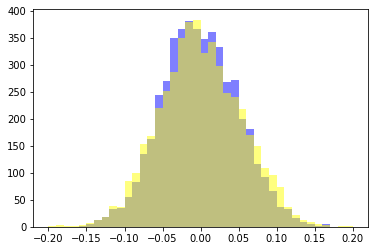

In [23]:
plt.hist(discreps_lv1, bins=np.linspace(-.2,.2,41), alpha=.5, color='blue');
plt.hist(discreps_lv0, bins=np.linspace(-.2,.2,41), alpha=.5, color='yellow');

Histogram above shows that we are closer to the Las Vegas model after adding in the lineup features

In [24]:
np.mean(np.abs(discreps_lv1)), np.mean(np.abs(discreps_lv0))

(0.039949780722521894, 0.04314676696536704)

Let's look at whether we get better predictions by making a weighted average of our model and the Las Vegas probs

In [25]:
weak_model_preds = d8['preds_test']
strong_model_preds = d1['preds_test']

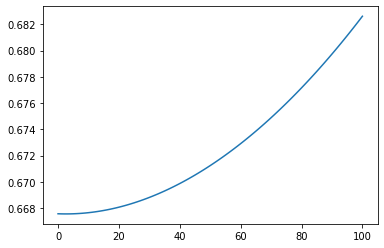

In [26]:
## Mixing in our first (very simple) model
ll_mix_vec_weak = [log_loss(y_test, (k*weak_model_preds+(1-k)*df_test.implied_prob_h_mid)) for k in np.linspace(0,1,101)]
plt.plot(ll_mix_vec_weak)

In [27]:
ll_mix_vec_weak[0] - np.min(ll_mix_vec_weak), np.argmin(ll_mix_vec_weak)

(1.1346372347231792e-05, 3)

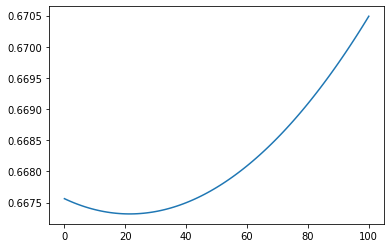

In [28]:
## Mixing in our latest model
ll_mix_vec_strong = [log_loss(y_test, (k*strong_model_preds+(1-k)*df_test.implied_prob_h_mid)) for k in np.linspace(0,1,101)]
plt.plot(ll_mix_vec_strong)

In [29]:
ll_mix_vec_strong[0] - np.min(ll_mix_vec_strong), np.argmin(ll_mix_vec_strong)

(0.0002446390976322821, 21)

In [30]:
# Simulate different model variations on a single test set
# Gives a sense of how much different models (each with the same quality)
# will vary
def ll_model_discrep_shuffle(probvec_true, discreps, num_trials, answers):
    # sim_outcome = np.random.binomial(n=1, p=probvec_true)
    llvec_mod = np.zeros(num_trials)
    discr1 = discreps.copy()
    for i in range(num_trials):
        np.random.shuffle(discr1)
        pv_mod = pv_true  + discr1
        llvec_mod[i] = log_loss(answers, pv_mod)
    return(llvec_mod)

In [31]:
pv_true = df_test.implied_prob_h_mid
losses = ll_model_discrep_shuffle(pv_true, discreps_lv1, 10000, y_test)

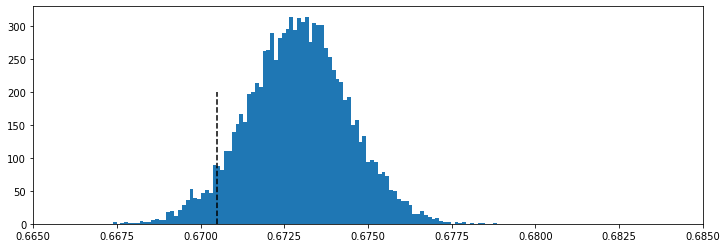

In [32]:
plt.figure(figsize=(12,4))
plt.hist(losses, bins=100);
plt.xlim([.665,.685]);
plt.vlines(x=log_loss(y_test, strong_model_preds), ymin=0, ymax=200, color='k', linestyle='--')

# Conclusions
- ## We went from ~40bps to ~30bps by adding lineup variables OBS, SLG (for home and away)
- ## Changing variants, adding more variables did not seem to improve at all
- ## Vegas model is still better overall, but evidence that our model captures effects that they don't


# Next Steps
- ## Want to model runs scored
- ## Will certainly be useful for predicting the over / under
- ## May also prove useful for predicting the winner of the game
- ## Will want to use probabilistic regression to get a distribution on the runs scored rather than a point estimate